In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Random seed for reproducibility
np.random.seed(17)

In [2]:
# ===================== LOAD AND CLEAN DATA =====================
data_ksi = pd.read_csv("./Total_KSI.csv")

# Initial data overview
"""Displays an overview of the dataset."""
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

print("\n===================== DATA OVERVIEW =====================")
print("\nFirst 3 Records:\n", data_ksi.head(3))
print("\nShape of the DataFrame:", data_ksi.shape)
print("\nData Types:\n", data_ksi.dtypes)

print("\n===================== DATA DESCRIPTION =====================")
print("\nStatistical Summary:\n", data_ksi.describe())

print("\n===================== COLUMN INFORMATION =====================")
data_ksi.info()

print("\n===================== MISSING VALUES =====================")
missing_data = data_ksi.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(data_ksi)) * 100
print(pd.concat([missing_data, missing_percent], axis=1, keys=['Total Missing', 'Percent Missing']))

print("\n===================== UNIQUE VALUES =====================")
for column in data_ksi.columns:
    print(f"\nUnique values in {column}:", data_ksi[column].unique())


# Drop unnecessary columns
columns_to_drop = [
    "OBJECTID",
    "INDEX",
    "FATAL_NO","x","y","OFFSET","HOOD_140","NEIGHBOURHOOD_140","HOOD_158","STREET1","STREET2"
]


===================== DATA OVERVIEW =====================

First 3 Records:
    OBJECTID    INDEX    ACCNUM                  DATE  TIME       STREET1  \
0         1  3389067  893184.0  1/1/2006 10:00:00 AM   236  WOODBINE AVE   
1         2  3389068  893184.0  1/1/2006 10:00:00 AM   236  WOODBINE AVE   
2         3  3389069  893184.0  1/1/2006 10:00:00 AM   236  WOODBINE AVE   

       STREET2 OFFSET      ROAD_CLASS               DISTRICT   LATITUDE  \
0  O CONNOR DR    NaN  Major Arterial  Toronto and East York  43.699595   
1  O CONNOR DR    NaN  Major Arterial  Toronto and East York  43.699595   
2  O CONNOR DR    NaN  Major Arterial  Toronto and East York  43.699595   

   LONGITUDE                ACCLOC    TRAFFCTL VISIBILITY LIGHT RDSFCOND  \
0 -79.318797  Intersection Related  No Control      Clear  Dark      Wet   
1 -79.318797  Intersection Related  No Control      Clear  Dark      Wet   
2 -79.318797  Intersection Related  No Control      Clear  Dark      Wet   

           

In [3]:
from imblearn.under_sampling import RandomUnderSampler

# Drop unnecessary columns
data_ksi.drop(columns=columns_to_drop, inplace=True)

# Handle missing target values and specific rows
data_ksi['ACCLASS'] = data_ksi['ACCLASS'].fillna('Fatal')
data_ksi.drop(data_ksi[data_ksi['ACCLASS'] == 'Property Damage O'].index, inplace=True)
data_ksi.drop_duplicates(inplace=True)

# Format date and time
data_ksi["DATE"] = pd.to_datetime(data_ksi["DATE"]).dt.to_period("D").astype(str)

# Extract date components from the 'DATE' column
data_ksi['MONTH'] = pd.to_datetime(data_ksi['DATE']).dt.month
data_ksi['DAY'] = pd.to_datetime(data_ksi['DATE']).dt.day
data_ksi['WEEK'] = pd.to_datetime(data_ksi['DATE']).dt.isocalendar().week
data_ksi['DAYOFWEEK'] = pd.to_datetime(data_ksi['DATE']).dt.dayofweek

# Extract hour from the 'TIME' column
data_ksi['HOUR'] = data_ksi['TIME'].apply(lambda x: int(str(x).zfill(4)[:2]))

# Replace specific values
data_ksi['ROAD_CLASS'] = data_ksi['ROAD_CLASS'].str.replace(r'MAJOR ARTERIAL ', 'MAJOR ARTERIAL', regex=False)

# Fill missing values
unknown_columns = ['PEDCOND', 'DRIVCOND', 'CYCLISTYPE', 'PEDACT', 'MANOEUVER', 'CYCACT','CYCCOND',
                   'INJURY', 'VEHTYPE', 'INVTYPE', 'IMPACTYPE', 'DISTRICT', 'INITDIR']
other_columns = ['ROAD_CLASS', 'ACCLOC', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'DRIVACT', 'INVAGE']
boolean_columns = ['PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH',
                   'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY','EMERG_VEH']

data_ksi[other_columns] = data_ksi[other_columns].fillna("Other")
data_ksi[unknown_columns] = data_ksi[unknown_columns].fillna("Unknown")
data_ksi[boolean_columns] = data_ksi[boolean_columns].fillna("No")

data_ksi["TRAFFCTL"] = data_ksi["TRAFFCTL"].fillna("No_Control")
data_ksi["PEDTYPE"] = data_ksi["PEDTYPE"].fillna("Other / Undefined")

# Convert boolean columns to numeric
pd.set_option('future.no_silent_downcasting', True)
data_ksi[boolean_columns] = data_ksi[boolean_columns].replace({'Yes': 1, 'No': 0}).astype(float)

# Handle age column
data_ksi['INVAGE'] = data_ksi['INVAGE'].replace('unknown', np.nan)
data_ksi['INVAGE'] = data_ksi['INVAGE'].str.replace('OVER 95', '95 to 100')
data_ksi[['min_age', 'max_age']] = data_ksi['INVAGE'].str.split(' to ', expand=True)
data_ksi['min_age'] = pd.to_numeric(data_ksi['min_age'], errors='coerce')
data_ksi['max_age'] = pd.to_numeric(data_ksi['max_age'], errors='coerce')
data_ksi['AVG_AGE'] = data_ksi[['min_age', 'max_age']].mean(axis=1).astype(float)
data_ksi.drop(columns=['INVAGE','min_age', 'max_age'], inplace=True)

# Handle class imbalance
rus = RandomUnderSampler(random_state=17)
X_res, y_res = rus.fit_resample(data_ksi.drop(columns=['ACCLASS']), data_ksi['ACCLASS'])
data_ksi = pd.concat([X_res, y_res], axis=1).sample(frac=1, random_state=17).reset_index(drop=True)

print("\n===================== DATA CLEANING DONE =====================")
print("\nShape of the DataFrame after cleaning:", data_ksi.shape)
print("Class Distribution:\n", data_ksi['ACCLASS'].value_counts())


===================== DATA CLEANING DONE =====================

Shape of the DataFrame after cleaning: (5174, 48)
Class Distribution:
 ACCLASS
Fatal               2587
Non-Fatal Injury    2587
Name: count, dtype: int64


In [4]:
# ===================== DEFINE PARAMETER GRIDS =====================
param_grid_svm = [
        {'svm__kernel': ['linear'], 'svm__C': [1]},  # linear kernel  
]

features = data_ksi.drop(columns=["ACCLASS"])
target = data_ksi["ACCLASS"]

unseen_features = features[-10:]
unseen_labels = target[-10:]

features = features[:-10]
target = target[:-10]

cleaned_df = data_ksi.drop(data_ksi.index[-10:])

# Encode the target variable
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

# Encode unseen labels
unseen_labels = label_encoder.transform(unseen_labels)

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Split the data into train & test
X_train, X_test, y_train, y_test = train_test_split(
        features, target, stratify=target, test_size=0.2, random_state=17)

# Preprocess the data
num_features = features.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = features.select_dtypes(include=['object']).columns.tolist()

print("\n===================== FEATURES INFO =====================")
print("\nNumerical Features:", num_features)
print("\nCategorical Features:", cat_features)

num_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='mode')),
        ('encoder', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

preprocessor = ColumnTransformer([
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

pipe_svm_ksi = Pipeline([
            ('preprocessor', preprocessor),
            ('svm', SVC(random_state=17))
        ])



===================== FEATURES INFO =====================

Numerical Features: ['ACCNUM', 'TIME', 'LATITUDE', 'LONGITUDE', 'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY', 'HOUR', 'AVG_AGE']

Categorical Features: ['DATE', 'ROAD_CLASS', 'DISTRICT', 'ACCLOC', 'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'IMPACTYPE', 'INVTYPE', 'INJURY', 'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND', 'NEIGHBOURHOOD_158', 'DIVISION']


In [6]:
grid_search = GridSearchCV(estimator=pipe_svm_ksi, param_grid=param_grid_svm, scoring='accuracy', refit=True, verbose=3)

In [7]:
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ......svm__C=1, svm__kernel=linear;, score=0.869 total time=  29.0s
[CV 2/5] END ......svm__C=1, svm__kernel=linear;, score=0.851 total time=  27.9s
[CV 3/5] END ......svm__C=1, svm__kernel=linear;, score=0.835 total time=  27.8s
[CV 4/5] END ......svm__C=1, svm__kernel=linear;, score=0.840 total time=  25.4s
[CV 5/5] END ......svm__C=1, svm__kernel=linear;, score=0.826 total time=  26.4s


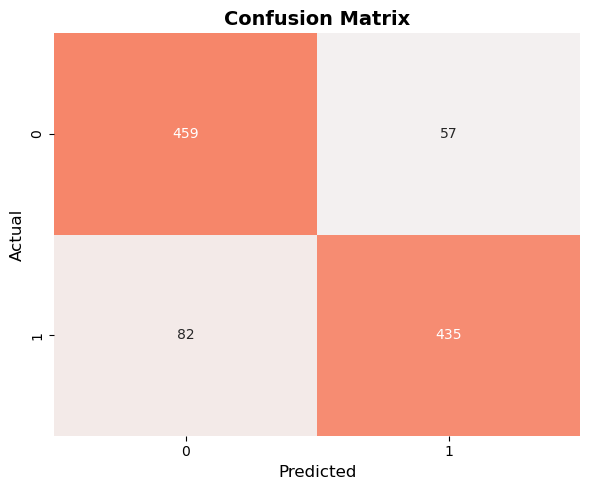


===================== CLASSIFICATION REPORT =====================

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87       516
           1       0.88      0.84      0.86       517

    accuracy                           0.87      1033
   macro avg       0.87      0.87      0.87      1033
weighted avg       0.87      0.87      0.87      1033


===================== PRECISION, RECALL, F1-SCORE =====================

Precision: 0.8663048767176569
Recall: 0.8654404646660213
F1-Score: 0.8653647640217719
ROC-AUC Score: 0.8654637668121092


In [8]:
from model_performance import ModelPerformance
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score

# Predict using the best model
y_pred = best_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

modelPerformance = ModelPerformance(best_model, X_test, y_test)
modelPerformance.conf_matrix("./confusion_matrix.png")

# Print classification report for detailed performance metrics
print("\n===================== CLASSIFICATION REPORT =====================")
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))

#Precison, Recall, F1-Score
print("\n===================== PRECISION, RECALL, F1-SCORE =====================")
print("\nPrecision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred, average='weighted'))

In [9]:
print("\n===================== BEST MODEL METRICS =====================")
print("\nBest Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)
print("Best Training Accuracy:", grid_search.best_score_)

accuracy = best_model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


===================== BEST MODEL METRICS =====================

Best Parameters: {'svm__C': 1, 'svm__kernel': 'linear'}
Best Estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ACCNUM', 'TIME', 'LATITUDE',
                                                   'LONGITUDE', 'PEDESTRIAN',
                                                   'CYCLIST', 'AUTOMOBILE',
                                                   'MOTORCYCLE', 'TRUCK',
                                                   'TRSN_CITY_VEH', 'EMERG_VEH',
                                      

In [10]:
 # Handling unseen data
best_model.fit(unseen_features, unseen_labels)
unseen_predictions = best_model.predict(unseen_features)
unseen_accuracy = best_model.score(unseen_features, unseen_labels)

print("\n===================== UNSEEN DATA METRICS =====================")
print("\nUnseen Predictions:", unseen_predictions)
for i in range(len(unseen_features)):
    print(f"Predicted: {unseen_predictions[i]} Actual: {unseen_labels[i]}")

print(f"Unseen Data Accuracy: {unseen_accuracy:.4f}")


===================== UNSEEN DATA METRICS =====================

Unseen Predictions: [1 1 1 0 0 1 0 0 0 1]
Predicted: 1 Actual: 1
Predicted: 1 Actual: 1
Predicted: 1 Actual: 1
Predicted: 0 Actual: 0
Predicted: 0 Actual: 0
Predicted: 1 Actual: 1
Predicted: 0 Actual: 0
Predicted: 0 Actual: 0
Predicted: 0 Actual: 0
Predicted: 1 Actual: 1
Unseen Data Accuracy: 1.0000


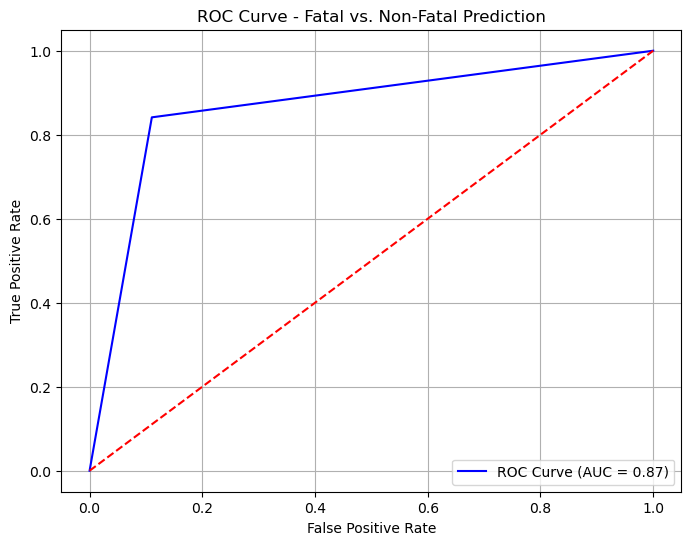

In [11]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred):.2f})', color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve - Fatal vs. Non-Fatal Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

              Feature  Importance Mean  Importance Std
0          PEDESTRIAN    -1.239109e-02        0.005658
1             CYCLIST    -8.906099e-03        0.005853
2             VEHTYPE    -8.518877e-03        0.003987
3            SPEEDING    -6.389158e-03        0.004687
4          ROAD_CLASS    -5.808325e-03        0.006508
5            DISTRICT    -3.097773e-03        0.004951
6             PEDCOND    -2.323330e-03        0.001313
7              PEDACT    -2.129719e-03        0.001877
8           PASSENGER    -1.936108e-03        0.004457
9             PEDTYPE    -1.742498e-03        0.000724
10          IMPACTYPE    -7.744434e-04        0.002832
11              LIGHT    -5.808325e-04        0.002974
12            ALCOHOL    -3.872217e-04        0.003496
13          EMERG_VEH     0.000000e+00        0.000000
14         AUTOMOBILE     0.000000e+00        0.000000
15            CYCCOND     0.000000e+00        0.000000
16      TRSN_CITY_VEH     0.000000e+00        0.000000
17        

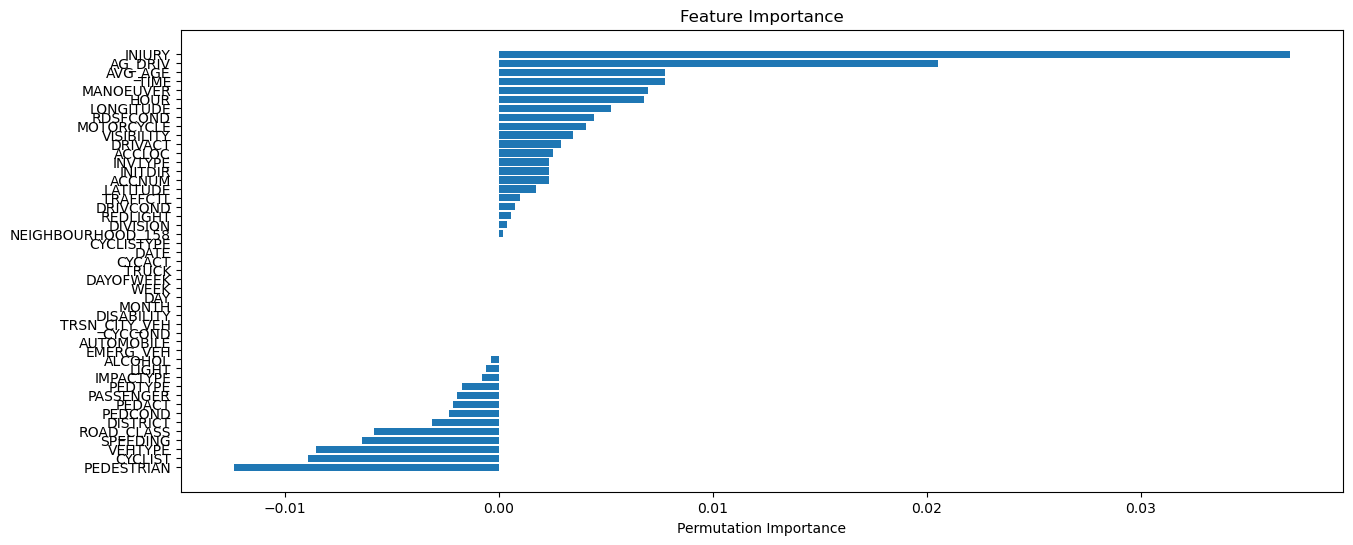

In [12]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

feature_names = features.columns if hasattr(features, 'columns') else [f"Feature {i}" for i in range(features.shape[1])]

perm_importance = permutation_importance(best_model, X_test, y_test)

sorted_idx = perm_importance.importances_mean.argsort()

importance_df = pd.DataFrame({
    "Feature": np.array(feature_names)[sorted_idx],
    "Importance Mean": perm_importance.importances_mean[sorted_idx],
    "Importance Std": perm_importance.importances_std[sorted_idx]
})

print(importance_df)

# Plot permutation importance
plt.figure(figsize=(15, 6))
plt.barh(np.array(feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()